# Proxy

In [22]:
# import library
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import copy

Allostery:
<div>
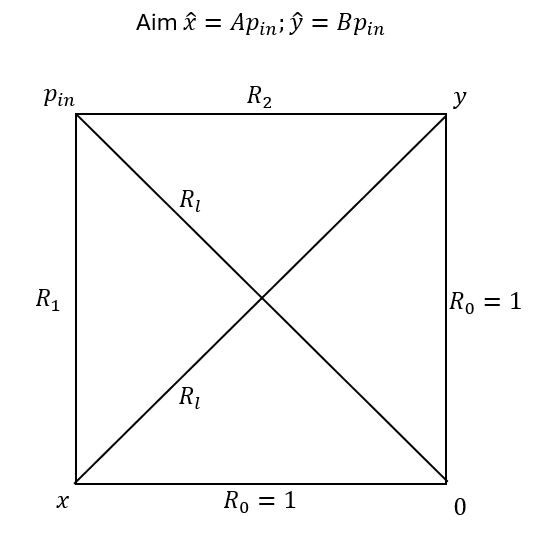
</div>


In [44]:
## Ugly Classes

class Syms():
    def __init__(self, variabs):
        super(Syms, self).__init__()
        if variabs.task_type == 'Allostery':
            self.x, self.y, self.R1, self.R2, self.Rl, self.p = sp.symbols('x, y, R1, R2, Rl, p')    
        elif variabs.task_type == 'Regression':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, R1, R2, Rl, p1, p2') 
        elif variabs.task_type == 'General_reg':
            self.x, self.y, self.z, self.R1, self.R2, self.R3, \
            self.R4, self.R5, self.R6, self.p1, self.p2 = sp.symbols('x, y, z, R1, R2, R3, R4, R5, R6, p1, p2') 
        elif variabs.task_type == 'General_reg_allRsChange':
            self.x, self.y, self.z, self.R1, self.R2, self.R3, self.R4, self.R5, self.R6, self.R7, self.R8, self.R9, \
            self.R10, self.R11, self.R12, self.R13, self.R14, self.R15, self.p1, self.p2 = sp.symbols('x y z R1 R2 R3 R4 R5 R6 R7 R8 R9 R10 R11 R12 R13 R14 R15 p1 p2')


In [49]:
## Classes

class Variabs():
    def __init__(self, task_type, alpha, gamma, use_p_tag=True):
        super(Variabs, self).__init__()
        self.task_type = task_type
        self.alpha = alpha
        self.gamma = gamma
        self.use_p_tag = use_p_tag 


class State():
    def __init__(self, syms, variabs, supress_prints, bc_noise):
        super(State, self).__init__()
        self.syms = syms
        self.variabs = variabs
        
        # self.R_in_t = [np.array([2.59272486, 5.18544973])]
        self.out_in_t = []
        self.loss_in_t = []
        self.t = 0
        
        # inital resistance, out_dual and p_in
        if self.variabs.task_type == 'Allostery':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5,0.5])]
            self.p_in_t = [1]
        elif self.variabs.task_type == 'Regression':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5])]
            # self.p_in_t = [np.array([0.5, 1.5])]
            self.p_in_t = [np.array([1, 1])]
        elif self.variabs.task_type == 'General_reg':
            self.R_in_t = [np.array([1.,1.,1.,1.,1.,1.])]
            # self.R_in_t = [np.array([18.7,2.4,4.0,-13.5,-12.8,1.5])]
            # self.R_in_t = [np.array([13.8,7.3,-1.5,-8.0,-2.4,-8.9])]
            self.out_dual_in_t = [0.5*np.ones(3)]
            self.p_in_t = [1.0*np.ones(2)]
        elif self.variabs.task_type == 'General_reg_allRsChange':
            self.R_in_t = [np.ones((15), dtype=float)]
            self.out_dual_in_t = [0.5*np.ones(3)]
            self.p_in_t = [1.0*np.ones(2)]
            
        # initalized drawn sample vec and loss func
        if self.variabs.task_type == 'Allostery':
            self.loss_fn = loss_fn_allostery
        else:
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
        self.supress_prints = supress_prints
        self.bc_noise=bc_noise
        
    def assign_P(self, syms):
        if self.variabs.task_type == 'Allostery':
            self.P = (syms.p-syms.x)**2/syms.R1 + (syms.p-syms.y)**2/syms.R2 + syms.x**2 + syms.y**2 + \
                     syms.p**2/syms.Rl + (syms.x-syms.y)**2/syms.Rl 
        elif self.variabs.task_type == 'Regression':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + syms.p1**2 + syms.p2**2 + \
                     syms.x**2/syms.Rl + (syms.p1-syms.p2)**2/syms.Rl
        elif self.variabs.task_type == 'General_reg':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + (syms.p1-syms.y)**2/syms.R3 + \
                     (syms.p2-syms.y)**2/syms.R4 + (syms.p1-syms.z)**2/syms.R5 + (syms.p2-syms.z)**2/syms.R6 + \
                     syms.p1**2 + syms.p2**2 + syms.x**2 + syms.y**2 + syms.z**2 + (syms.p1-syms.p2)**2 + \
                     (syms.x-syms.y)**2 + (syms.y-syms.z)**2 + (syms.x-syms.z)**2
        elif self.variabs.task_type == 'General_reg_allRsChange':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + (syms.p1-syms.y)**2/syms.R3 + \
                     (syms.p2-syms.y)**2/syms.R4 + (syms.p1-syms.z)**2/syms.R5 + (syms.p2-syms.z)**2/syms.R6 + \
                     syms.p1**2/syms.R7 + syms.p2**2/syms.R8 + syms.x**2/syms.R9 + syms.y**2/syms.R10 + \
                     syms.z**2/syms.R11 + (syms.p1-syms.p2)**2/syms.R12 + (syms.x-syms.y)**2/syms.R13 + \
                     (syms.y-syms.z)**2/syms.R14 + (syms.x-syms.z)**2/syms.R15
            
    def solve_pressure(self, syms):        
        if self.variabs.task_type == 'Allostery':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            sols = sp.solve([dPdx,dPdy],[syms.x,syms.y])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
        elif self.variabs.task_type == 'Regression':
            dPdx = self.P.diff(syms.x)
            sols = sp.solve([dPdx],[syms.x])
            self.x = sols[syms.x]
        elif self.variabs.task_type == 'General_reg' or self.variabs.task_type == 'General_reg_allRsChange':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            dPdz = self.P.diff(syms.z)
            sols = sp.solve([dPdx,dPdy,dPdz],[syms.x,syms.y,syms.z])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
            self.z = sols[syms.z]
    
    def calc_output(self, syms):
        # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
        if self.variabs.task_type == 'Allostery':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            self.output = np.array([x_nxt, y_nxt])
        elif self.variabs.task_type == 'Regression':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p1:self.p_drawn[0],
                                 syms.p2:self.p_drawn[1], syms.Rl:2**(1/2)})
            self.output = x_nxt
        elif self.variabs.task_type == 'General_reg':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            z_nxt = self.z.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            self.output = np.array([x_nxt, y_nxt, z_nxt])
        elif self.variabs.task_type == 'General_reg_allRsChange':
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.R7:self.R_in_t[-1][6], syms.R8:self.R_in_t[-1][7], syms.R9:self.R_in_t[-1][8],\
                                 syms.R10:self.R_in_t[-1][9], syms.R11:self.R_in_t[-1][10], syms.R12:self.R_in_t[-1][11],\
                                 syms.R13:self.R_in_t[-1][12], syms.R14:self.R_in_t[-1][13], syms.R15:self.R_in_t[-1][14],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.R7:self.R_in_t[-1][6], syms.R8:self.R_in_t[-1][7], syms.R9:self.R_in_t[-1][8],\
                                 syms.R10:self.R_in_t[-1][9], syms.R11:self.R_in_t[-1][10], syms.R12:self.R_in_t[-1][11],\
                                 syms.R13:self.R_in_t[-1][12], syms.R14:self.R_in_t[-1][13], syms.R15:self.R_in_t[-1][14],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            z_nxt = self.z.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.R7:self.R_in_t[-1][6], syms.R8:self.R_in_t[-1][7], syms.R9:self.R_in_t[-1][8],\
                                 syms.R10:self.R_in_t[-1][9], syms.R11:self.R_in_t[-1][10], syms.R12:self.R_in_t[-1][11],\
                                 syms.R13:self.R_in_t[-1][12], syms.R14:self.R_in_t[-1][13], syms.R15:self.R_in_t[-1][14],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            self.output = np.array([x_nxt, y_nxt, z_nxt])
            
        # display and save output in time
        if self.supress_prints:
            pass
        else:
            print('output=', self.output)
        self.out_in_t.append(self.output)
    
    def calc_loss(self, desired, output_prev=0, desired_prev=0):
        if type(output_prev)==int and type(desired)!=np.float64:  # if desired not scalar, must change other sizes as well
            output_prev = np.zeros(len(desired))
            desired_prev = np.zeros(len(desired))
        if self.variabs.task_type=='Allostery':
            self.loss = self.loss_fn(self.output, desired)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg' \
             or self.variabs.task_type=='General_reg_allRsChange':
            self.loss = self.loss_fn(self.output, output_prev, desired, desired_prev)
        self.loss_in_t.append(self.loss)
        
    def update_pressure(self):
        self.t += 1
        loss = self.loss_in_t[-1]
        p = self.p_in_t[-1]
        pert = np.random.normal(size=np.size(p))
        if self.variabs.task_type == 'Allostery':     
            p_nxt = p - np.dot(self.variabs.alpha, loss+self.bc_noise*pert)
        elif self.variabs.task_type == 'Regression' or self.variabs.task_type=='General_reg' \
             or self.variabs.task_type=='General_reg_allRsChange':
            p_drawn = self.p_drawn_in_t[-1]
            if self.variabs.use_p_tag:
                p_drawn_prev = self.p_drawn_in_t[-2]
                p_nxt = p - (p_drawn-p_drawn_prev)*np.dot(self.variabs.alpha, loss[0]-loss[1])
#             p_nxt = p - np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1]))
#             print('the dot for p', np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1])))
                print('the dot for p', np.dot(self.variabs.alpha, loss[0]-loss[1]))
            else:
                p_nxt = p - (p_drawn)*np.dot(self.variabs.alpha, loss[0])          
                print('the dot for p', np.dot(self.variabs.alpha, loss[0]))            
        if self.supress_prints:
            pass
        else:
            print('loss=', loss)
            print('time=', self.t)
            print('p_nxt=', p_nxt)
        self.p_in_t.append(p_nxt)
        
    def update_BCs(self, desired):
        loss = self.loss_in_t[-1]
        pert = np.random.normal(size=np.size(self.output))
        out_dual = self.out_dual_in_t[-1]
        if self.variabs.task_type=='Allostery':
            self.output = out_dual + self.variabs.alpha * (loss + self.bc_noise*pert)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg' \
        or self.variabs.task_type=='General_reg_allRsChange':
#             print('output', self.output)
#             print('output_prev', self.out_in_t[-2])
            # self.output = out_dual + self.variabs.alpha * np.dot(self.output-self.out_in_t[-2], loss[0]-loss[1])
            self.output = out_dual + self.variabs.alpha * (self.output-self.out_in_t[-2])*(loss[0]-loss[1])
        self.out_dual_in_t.append(self.output)           
        if self.supress_prints:
            pass
        else:
            print('dual output', self.output)
    
    def update_Rs(self):
        if self.variabs.task_type=='Allostery' or self.variabs.task_type=='Regression':
            self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output))
        elif self.variabs.task_type=='General_reg':
            R_ij = []
            print(self.p_in_t[-1])
            for i, p in enumerate(self.p_in_t[-1]):
                for j, out in enumerate(self.output):
                    R_ij.append(self.variabs.gamma[i*len(self.output)+j] * (p - out))
            self.R_in_t.append(R_ij)
            # self.R_in_t.append(self.R_in_t[0])
        elif self.variabs.task_type=='General_reg_allRsChange':
            R_ij = []
            # inputs to outputs
            for i, p in enumerate(self.p_in_t[-1]):
                for j, out in enumerate(self.output):
                    R_ij.append(self.variabs.gamma[i*len(self.output)+j] * (p - out))
            # input to ground
            for i, p in enumerate(self.p_in_t[-1]):
                R_ij.append(self.variabs.gamma[i] * (p - 0))
            # outputs to ground
            for j, out, in enumerate(self.output):
                R_ij.append(self.variabs.gamma[j] * (out - 0))
            # inputs between themselves
            R_ij.append(self.variabs.gamma[0] * (self.p_in_t[-1][0] - self.p_in_t[-1][1]))
            # outputs between themselves
            for i, out in enumerate(self.output):
                R_ij.append(self.variabs.gamma[0] * (self.output[i] - self.output[(i+1)%3]))
            self.R_in_t.append(R_ij)
            
        # optionally display resistances
        if self.supress_prints:
            pass
        else:
            print('R_nxt', self.R_in_t[-1])
            
    def draw_p(self):
        self.p_drawn = np.random.uniform(low=0.0, high=2.0, size=2)
        self.p_drawn_in_t.append(self.p_drawn)
        # self.p_in_t[-1] = p_drawn
        # x=5
        
    def update_alpha(self, alpha):
        if self.variabs.task_type == 'Allostery':
            self.variabs.alpha = np.array([alpha, alpha])
        else:
            self.variabs.alpha = alpha
        # print('new alpha=', self.variabs.alpha)

In [50]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, training, supress, bc_noise=0, use_p_tag=True):
    if task_type=='Allostery':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec))
        print('alpha_vec', alpha_vec)
        gamma = np.array([1.0, 1.0])  # how much resistance changed due to pressure difference
        x_hat = 0.2
        y_hat = 0.3
        desired = np.array([x_hat, y_hat])
        A = copy.copy(x_hat)
        B = copy.copy(y_hat)
    elif task_type=='Regression':
        gamma = np.array([1.0])  # how much resistance changed due to pressure difference
        A = 0.4
        B = 0.25
        AB_vec = np.array([A, B])  # this is in terms of A & B, the calculated desired pressure is calculated in train loop
    elif task_type=='General_reg' or task_type=='General_reg_allRsChange':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec, alpha_vec))
        print(alpha_vec)
        gamma = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  # how much resistance changed due to pressure difference
        A = 0.05
        B = 0.25
        C = 0.1
        D = 0.15
        E = 0.02
        F = 0.3
        M = np.array([[A, B],  
                      [C, D], 
                      [E, F]])  # this is in terms of M matrix, desired press. is calculated in train loop
    
    for j, alpha in enumerate(alpha_vec):
#        print(alpha)
        ## classes for variables and symbols
        variabs = Variabs(task_type, alpha, gamma, use_p_tag=use_p_tag)
        syms = Syms(variabs)

        ## network state
        state = State(syms, variabs, supress_prints=supress, bc_noise=bc_noise)
        state.assign_P(syms)
        state.solve_pressure(syms)
        
        for i in range(training):
            if task_type=='Allostery':
                if np.size(alpha)>2:  # if alpha is annealed, change. In allostery alpha is 2D anyway
                    state.update_alpha(alpha[i])
                state.calc_output(syms)
                state.calc_loss(desired)
                state.update_pressure()
                state.update_BCs(desired)
                state.update_Rs()
            elif task_type=='Regression' or task_type=='General_reg' or task_type=='General_reg_allRsChange':
                if task_type=='Regression' and np.size(alpha)>1 :
                    state.update_alpha(alpha(i))
                state.draw_p()
                if task_type=='Regression':
                    desired = np.dot(AB_vec, state.p_drawn)
                else:
                    desired = np.matmul(M, state.p_drawn)
                state.desired_in_t.append(desired)
                if supress:
                    pass
                else:
                    print('p_drawn', state.p_drawn)
                    print('desired', desired)
                state.calc_output(syms)
                if not i % 2:  # even iterations
                    pass
                else:
                    if use_p_tag:
                        state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
                    else:
                        state.calc_loss(desired)
                    state.update_pressure()
                    state.update_BCs(desired)
                    state.update_Rs()
        # print(state.p_in_t)
        plot_importants(state, variabs, desired, A, B)
    return state, variabs, desired


def plot_importants(state, variabs, desired, A=1, B=1):
    if variabs.task_type == 'Allostery':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
        Rl_subs = 2**(1/2)
        R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$', r'$\frac{y}{y\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$y\,\mathrm{dual}$', r'$p\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_1\,\mathrm{theoretical}$', r'$R_2\,\mathrm{theoretical}$']
    elif variabs.task_type == 'Regression':
        Rl_subs = 2**(1/2)
        R_theor = np.array([Rl_subs*(1-A-B)/A, Rl_subs*(1-A-B)/B])
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$p_1\,\mathrm{dual}$', r'$p_2\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_1\,\mathrm{theoretical}$', r'$R_2\,\mathrm{theoretical}$']
    elif variabs.task_type=='General_reg' or variabs.task_type=='General_reg_allRsChange':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
#         C = desired[2]/state.p_in_t[0]  # B = y_hat/p_in
#         D = desired[3]/state.p_in_t[0]  # B = y_hat/p_in
#         E = desired[4]/state.p_in_t[0]  # B = y_hat/p_in
#         F = desired[5]/state.p_in_t[0]  # B = y_hat/p_in
        # R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        # legend1 = ['x', 'y', 'z', 'x desired', 'y deisred', 'z desired']
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$', r'$\frac{y}{y\,\mathrm{desired}}$', \
                   r'$\frac{z}{z\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$y\,\mathrm{dual}$', r'$z\,\mathrm{dual}$', r'$p_1\,\mathrm{dual}$',
                   r'$p_2\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_3$', r'$R_4$', r'$R_5$', r'$R_6$']
        R_theor = []  # I didn't calculate it for this task
    legend4 = ['|loss|']
    print('R theoretical', R_theor)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3.2))
    if variabs.task_type=='Allostery':
        ax1.plot(state.out_in_t[1:]/desired-1)
    # regression goes only every two samples
    elif variabs.task_type=='Regression' or variabs.task_type=='General_reg' or variabs.task_type=='General_reg_allRsChange':
        ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, \
                 np.asarray(state.out_in_t[1:])/np.asarray(state.desired_in_t[1:])-1)
    ax1.set_title('output in time')
    ax1.set_xlabel('t')
    ax1.legend(legend1)
    ax2.plot(state.out_dual_in_t[1:])
    ax2.plot(state.p_in_t[1:])
    ax2.set_title('dual and p in time')
    ax2.set_xlabel('t')
    ax2.legend(legend2)
    ax3.plot(state.R_in_t[1:])
    ax3.plot(np.outer(R_theor,np.ones(state.t)).T, '--')
    ax3.set_title('R in time')
    ax3.set_xlabel('t')
    ax3.legend(legend3)
    if variabs.task_type=='Allostery' or variabs.task_type=='Regression':  # loss is 2D in Allostery
        ax4.plot(np.abs(state.loss_in_t[1:]))
    elif variabs.task_type=='General_reg' or variabs.task_type=='General_reg_allRsChange':    
        ax4.plot(np.mean(np.mean(np.abs(state.loss_in_t[1:]), axis=1),axis=1))
    ax4.set_xlabel('t')
    ax4.legend(legend4)
    fig.suptitle(f'alpha={variabs.alpha}')
    plt.show()
    # print(state.R_in_t)

def loss_fn_allostery(output, desired):
    # return np.sign(desired-output)
    # return np.e**(-(desired-output)
    return desired-output
    # return np.sign(desired-output) * np.e**(-np.abs((desired-output)))
    
def loss_fn_regression(output1, output2, desired1, desired2):
    L1 = desired1-output1
    L2 = desired2-output2
    return np.array([L1, L2])

In [87]:
## Parameters

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
alpha_vec = np.array([0.1])
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])

# task - allostery or regression by now
# task_type = 'Allostery'
# task_type = 'Regression'
# task_type = 'General_reg'
task_type = 'General_reg_allRsChange'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    training=len(alpha_vec[0])
else:
    training=620

[[0.1 0.1 0.1]]
p_drawn [0.37406886 0.69303951]
desired [0.19196332 0.14136281 0.21539323]
output= [0.355702790942430 0.355702790942430 0.355702790942430]
p_drawn [0.28605877 0.8601163 ]
desired [0.22933201 0.15762332 0.26375607]
output= [0.382058358667051 0.382058358667051 0.382058358667051]
the dot for p 0.00229253357545865
loss= [[-0.152726344588370 -0.224435035997280 -0.118302292756956]
 [-0.163739470282402 -0.214339978155035 -0.140309560659755]]
time= 1
p_nxt= [1.00020176608201 0.999616970846265]
dual output [0.500029025718009 0.499973393901935 0.500058001403965]
R_nxt [0.500172740363999, 0.500228372180072, 0.500143764678043, 0.499587945128256, 0.499643576944330, 0.499558969442301, 1.00020176608201, 0.999616970846265, 0.500029025718009, 0.499973393901935, 0.500058001403965, 0.000584795235742397, 5.56318160734315e-5, -8.46075020291548e-5, 2.89756859557233e-5]
p_drawn [1.28489005 1.78854507]
desired [0.51138077 0.39677077 0.56226132]
output= [1.02460887176300 1.02455732237927 1.0246

output= [0.259027555487318 0.253995907914720 0.261604848951490]
p_drawn [1.15903681 1.37767154]
desired [0.40236972 0.32255441 0.4364822 ]
output= [0.636981341806702 0.615308564263933 0.646704654520785]
the dot for p -0.0463408927101821
loss= [[-0.234611617030779 -0.292754152398109 -0.210222457361261]
 [-0.0847171233392586 -0.120523442441073 -0.0689387339079964]]
time= 11
p_nxt= [1.54090745760431 1.20670703228902]
dual output [0.429440070359313 0.413509881208805 0.435368093556589]
R_nxt [1.11146738724499, 1.12739757639550, 1.10553936404772, 0.777266961929706, 0.793197151080214, 0.771338938732430, 1.54090745760431, 1.20670703228902, 0.429440070359313, 0.413509881208805, 0.435368093556589, 0.334200425315287, 0.0159301891505083, -0.0218582123477840, 0.00592802319727576]
p_drawn [1.53991083 0.7553684 ]
desired [0.26583764 0.26729634 0.25740874]
output= [0.550443057612522 0.500679742523927 0.570204728996743]
p_drawn [1.2276289  1.16418421]
desired [0.3524275  0.29739052 0.37380784]
output= 

output= [0.616391925809736 0.527610642682963 0.640975004887919]
p_drawn [1.16453174 1.1435028 ]
desired [0.34410229 0.28797859 0.36634148]
output= [0.548654325737645 0.518285114513382 0.558048065047790]
the dot for p 0.0309262168343548
loss= [[-0.204552038680043 -0.230306520798990 -0.191706589995713]
 [-0.333275139803339 -0.226086310008833 -0.376465868006123]]
time= 21
p_nxt= [1.71443616606352 1.15158065548401]
dual output [0.420537931881614 0.405100893660021 0.424115093101757]
R_nxt [1.29389823418191, 1.30933527240350, 1.29032107296176, 0.731042723602394, 0.746479761823987, 0.727465562382251, 1.71443616606352, 1.15158065548401, 0.420537931881614, 0.405100893660021, 0.424115093101757, 0.562855510579513, 0.0154370382215931, -0.0190141994417359, 0.00357716122014279]
p_drawn [1.16851668 0.3081605 ]
desired [0.13546596 0.16307574 0.11581848]
output= [0.343522278506146 0.279377864753800 0.359124051504854]
p_drawn [1.29315093 1.0805542 ]
desired [0.3347961  0.29139822 0.35002928]
output= [0.

output= [0.468573515955304 0.504659426252913 0.462690231139135]
p_drawn [1.53203572 1.3811454 ]
desired [0.42188814 0.36037538 0.44498434]
output= [0.624575356637276 0.583340109704066 0.633905475826169]
the dot for p -0.0425322882878462
loss= [[-0.202687219534092 -0.222964727150192 -0.188921140040612]
 [-0.0284449408434650 -0.207185376414349 0.0463801134113795]]
time= 31
p_nxt= [1.94590201688685 1.22311857184786]
dual output [0.397559365002527 0.384956725835085 0.399192070404916]
R_nxt [1.54834265188432, 1.56094529105176, 1.54670994648193, 0.825559206845329, 0.838161846012772, 0.823926501442940, 1.94590201688685, 1.22311857184786, 0.397559365002527, 0.384956725835085, 0.399192070404916, 0.722783445038989, 0.0126026391674423, -0.0142353445698316, 0.00163270540238930]
p_drawn [1.57473248 1.23559998]
desired [0.38763662 0.34281325 0.40217465]
output= [0.597653879155192 0.552489292092543 0.604261939889348]
p_drawn [1.37684488 1.49952405]
desired [0.44372326 0.3626131  0.47739411]
output= [

output= [0.462723508121024 0.383192457549464 0.478292261910846]
p_drawn [0.71156204 1.72034636]
desired [0.46566469 0.32920816 0.53033515]
output= [0.484507421545102 0.505344803656732 0.482602920224407]
the dot for p 0.0367526804676176
loss= [[-0.0188427296135718 -0.176136645639466 0.0477322284600875]
 [-0.191103603495283 -0.106123914067040 -0.217546433906803]]
time= 41
p_nxt= [2.19064175055481 1.23977540820197]
dual output [0.381543197241613 0.358256841878611 0.385177510958061]
R_nxt [1.80909855331320, 1.83238490867620, 1.80546423959675, 0.858232210960360, 0.881518566323363, 0.854597897243913, 2.19064175055481, 1.23977540820197, 0.381543197241613, 0.358256841878611, 0.385177510958061, 0.950866342352837, 0.0232863553630026, -0.0269206690794503, 0.00363431371644773]
p_drawn [0.73090096 0.61792841]
desired [0.19102715 0.16577936 0.19999654]
output= [0.267235781535575 0.241823709412314 0.272120340806229]
p_drawn [1.23970827 0.38388652]
desired [0.15795704 0.18155381 0.13996012]
output= [0

output= [0.538421475720056 0.537321647104122 0.541628514566716]
p_drawn [0.77648871 1.74960341]
desired [0.47622529 0.34008938 0.5404108 ]
output= [0.495150634909614 0.507525906370405 0.495588573048742]
the dot for p 0.00639637965601345
loss= [[-0.0189253472832480 -0.167436523806774 0.0448222235384339]
 [-0.0446736815716022 -0.172532774733548 0.0117030121934282]]
time= 51
p_nxt= [2.26173991995585 1.26435076431789]
dual output [0.376145581951548 0.347513515567727 0.381570205731759]
R_nxt [1.88559433800430, 1.91422640438812, 1.88016971422409, 0.888205182366346, 0.916837248750167, 0.882780558586135, 2.26173991995585, 1.26435076431789, 0.376145581951548, 0.347513515567727, 0.381570205731759, 0.997389155637953, 0.0286320663838209, -0.0340566901640317, 0.00542462378021080]
p_drawn [1.00415986 0.9539628 ]
desired [0.28869869 0.24351041 0.30627204]
output= [0.376765915666255 0.341672809764472 0.385407593456007]
p_drawn [0.72945012 1.55488611]
desired [0.42519403 0.30617793 0.48105484]
output= 

output= [0.192760594376664 0.201455035457138 0.194042433273109]
p_drawn [0.29073993 1.90808758]
desired [0.49155889 0.31528713 0.57824107]
output= [0.476958637293252 0.520682413798258 0.475213482438104]
the dot for p -0.00276760462037585
loss= [[0.0146002545184301 -0.205395283307079 0.103027590362104]
 [-0.00617182684959672 -0.0761594907214455 0.0222399253482561]]
time= 61
p_nxt= [2.33194008103195 1.14711196508234]
dual output [0.385645184427651 0.322660807667865 0.400764234212634]
R_nxt [1.94629489660430, 2.00927927336409, 1.93117584681932, 0.761466780654689, 0.824451157414475, 0.746347730869706, 2.33194008103195, 1.14711196508234, 0.385645184427651, 0.322660807667865, 0.400764234212634, 1.18482811594961, 0.0629843767597856, -0.0781034265447687, 0.0151190497849831]
p_drawn [1.58887003 1.65693123]
desired [0.49367631 0.40742669 0.52885677]
output= [0.666888865780800 0.578271248027133 0.699694372089907]
p_drawn [0.69356455 0.61871008]
desired [0.18935575 0.16216297 0.19948432]
output= [

output= [0.413498694741278 0.331816981568545 0.445185026458254]
p_drawn [0.14089259 1.11785541]
desired [0.28650848 0.18176757 0.33817448]
output= [0.270114646528447 0.282984471938021 0.275147088892079]
the dot for p 0.0297608554799027
loss= [[0.0163938359981714 -0.101216901057314 0.0630273865028716]
 [-0.114188763898761 -0.0751641426043296 -0.130051326852209]]
time= 71
p_nxt= [2.50549947169700 1.13395987204280]
dual output [0.379308825136898 0.295869792880353 0.399684374549105]
R_nxt [2.12619064656011, 2.20962967881665, 2.10581509714790, 0.754651046905899, 0.838090079162443, 0.734275497493691, 2.50549947169700, 1.13395987204280, 0.379308825136898, 0.295869792880353, 0.399684374549105, 1.37153959965421, 0.0834390322565446, -0.103814581668752, 0.0203755494122076]
p_drawn [1.94807669 1.28452887]
desired [0.41853605 0.387487   0.4243202 ]
output= [0.632687608673812 0.478621345324131 0.685680219590206]
p_drawn [0.42810537 0.9606969 ]
desired [0.26157949 0.18691507 0.29677118]
output= [0.28

output= [0.658252216303256 0.523365210363317 0.701066467367278]
p_drawn [0.82851477 0.44113853]
desired [0.15171037 0.14902226 0.14891185]
output= [0.229669643913656 0.162496238611357 0.248532469747277]
the dot for p 0.0193367610263848
loss= [[-0.0779592725461543 -0.0134739816777994 -0.0996206150280219]
 [-0.143298358526103 -0.0828124659656983 -0.158310655024023]]
time= 81
p_nxt= [2.74099562835713 1.19461028591450]
dual output [0.360421277556954 0.277756589188639 0.377693173728909]
R_nxt [2.38057435080018, 2.46323903916849, 2.36330245462822, 0.834189008357548, 0.916853696725862, 0.816917112185593, 2.74099562835713, 1.19461028591450, 0.360421277556954, 0.277756589188639, 0.377693173728909, 1.54638534244263, 0.0826646883683143, -0.0999365845402694, 0.0172718961719551]
p_drawn [1.14793278 1.04698603]
desired [0.31914315 0.27184118 0.33705446]
output= [0.397316546926061 0.316033449228790 0.423338368125699]
p_drawn [0.94481488 1.68130333]
desired [0.46756658 0.34667699 0.5232873 ]
output= [

output= [0.393366887826917 0.377068434305040 0.409988351879916]
p_drawn [1.06423064 0.20687808]
desired [0.10493105 0.13745478 0.08334804]
output= [0.218116003673193 0.119236650297601 0.246180798165977]
the dot for p -0.0265477971883955
loss= [[-0.113184952852917 0.0182181248744177 -0.162832762712990]
 [0.0260407951093140 -0.0933158909165556 0.0749534769997077]]
time= 91
p_nxt= [2.82103747382302 1.13000921567837]
dual output [0.363558789448058 0.261719347264745 0.386827022408712]
R_nxt [2.45747868437497, 2.55931812655828, 2.43421045141431, 0.766450426230308, 0.868289868413621, 0.743182193269654, 2.82103747382302, 1.13000921567837, 0.363558789448058, 0.261719347264745, 0.386827022408712, 1.69102825814466, 0.101839442183313, -0.125107675143967, 0.0232682329606543]
p_drawn [0.80380514 1.68246458]
desired [0.4608064  0.3327502  0.52081548]
output= [0.482507566371862 0.431692999557404 0.511047113245692]
p_drawn [1.23867085 0.6644622 ]
desired [0.22804909 0.22353642 0.22411208]
output= [0.34

output= [0.240320919114591 0.137349729777366 0.266530005655613]
p_drawn [1.8505439 0.0637421]
desired [0.10846272 0.1946157  0.05613351]
output= [0.316473415376327 0.127120769100601 0.360617728686648]
the dot for p -0.0211490698021974
loss= [[-0.208010696379279 0.0674949350631713 -0.304484221756215]
 [-0.105085909787047 0.0185357437060579 -0.146959118969359]]
time= 101
p_nxt= [3.02789913187285 1.11666454187490]
dual output [0.351647411365591 0.252026432004971 0.370146897583008]
R_nxt [2.67625172050726, 2.77587269986788, 2.65775223428984, 0.765017130509311, 0.864638109869931, 0.746517644291893, 3.02789913187285, 1.11666454187490, 0.351647411365591, 0.252026432004971, 0.370146897583008, 1.91123458999795, 0.0996209793606198, -0.118120465578037, 0.0184994862174175]
p_drawn [0.42860056 1.83190491]
desired [0.47940625 0.31764579 0.55814348]
output= [0.434366291402615 0.431924034553192 0.448397099971931]
p_drawn [1.55880072 0.82414487]
desired [0.28397625 0.2795018  0.27841947]
output= [0.420

output= [0.441821385066379 0.326825277952819 0.469194363260744]
p_drawn [1.12217819 0.76417123]
desired [0.24715172 0.2268435  0.25169493]
output= [0.330111932862664 0.232532710905021 0.352199332733057]
the dot for p 0.00279307987350732
loss= [[-0.0829602159142431 -0.00568920750916085 -0.100504399953127]
 [-0.0920873934562598 -0.0201486851134046 -0.104848543541940]]
time= 111
p_nxt= [3.21290814685968 1.09375476739213]
dual output [0.341002945106327 0.244984503647128 0.355192544038775]
R_nxt [2.87190520175335, 2.96792364321255, 2.85771560282090, 0.752751822285802, 0.848770263745002, 0.738562223353354, 3.21290814685968, 1.09375476739213, 0.341002945106327, 0.244984503647128, 0.355192544038775, 2.11915337946755, 0.0960184414591996, -0.110208040391648, 0.0141895989324479]
p_drawn [1.9975211  0.42524784]
desired [0.20618802 0.26353929 0.16752478]
output= [0.406300393357280 0.205314455330881 0.444956256579176]
p_drawn [0.97097834 0.33120474]
desired [0.1313501  0.14677855 0.11878099]
output=

output= [0.122975901466480 0.136796582838510 0.124847445777642]
p_drawn [0.58763551 0.47265805]
desired [0.14754629 0.12966226 0.15355012]
output= [0.194295813777395 0.139656591570138 0.208012661471582]
the dot for p -0.0137651337821197
loss= [[-0.0467495267207315 -0.00999433397535329 -0.0544625372097502]
 [0.0235714927156845 -0.0471597583240345 0.0500332055237116]]
time= 121
p_nxt= [3.31960058434923 1.01902629281347]
dual output [0.341298791084532 0.233770577421657 0.357043933431682]
R_nxt [2.97830179326470, 3.08583000692758, 2.96255665091755, 0.677727501728943, 0.785255715391818, 0.661982359381793, 3.31960058434923, 1.01902629281347, 0.341298791084532, 0.233770577421657, 0.357043933431682, 2.30057429153576, 0.107528213662875, -0.123273356010025, 0.0157451423471506]
p_drawn [1.52469189 1.42334528]
desired [0.43207091 0.36597098 0.45749742]
output= [0.544235312371730 0.408748537244502 0.579512716676532]
p_drawn [0.22069632 0.50805528]
desired [0.13804864 0.09827792 0.15683051]
output= 

output= [0.296436446273244 0.353968371699507 0.296408634984123]
p_drawn [0.8205094  0.49719281]
desired [0.16532367 0.15662986 0.16556803]
output= [0.225630678680442 0.152260820118939 0.236766034060525]
the dot for p -0.0274746210955506
loss= [[-0.0603070054365701 0.00436904207762223 -0.0711980023108724]
 [0.0942703678117321 -0.118506839371062 0.171846716845016]]
time= 131
p_nxt= [3.52058112889434 1.01142806843122]
dual output [0.326801642026104 0.229695440642364 0.336385979152302]
R_nxt [3.19377948686823, 3.29088568825197, 3.18419514974203, 0.684626426405117, 0.781732627788857, 0.675042089278919, 3.52058112889434, 1.01142806843122, 0.326801642026104, 0.229695440642364, 0.336385979152302, 2.50915306046312, 0.0971062013837404, -0.106690538509938, 0.00958433712619750]
p_drawn [1.36512248 1.46859766]
desired [0.43540554 0.3568019  0.46788175]
output= [0.507162580382285 0.405462304942560 0.526699499674685]
p_drawn [0.89552795 0.54490391]
desired [0.18100238 0.17128838 0.18138173]
output= [

output= [0.321728076220369 0.227181483480631 0.340437571234477]
p_drawn [0.11915079 1.04175866]
desired [0.26639721 0.16817888 0.31491061]
output= [0.217836243944575 0.236687328961816 0.221224498039220]
the dot for p 0.0212335865006158
loss= [[0.0485609611664513 -0.0685084504593312 0.0936861164163729]
 [-0.0647768754401058 -8.85765362906854e-6 -0.0738115047889301]]
time= 141
p_nxt= [3.64537751246621 1.00573408589803]
dual output [0.319800793577062 0.218468622645146 0.330966979246035]
R_nxt [3.32557671888915, 3.42690888982106, 3.31441053322017, 0.685933292320966, 0.787265463252882, 0.674767106651992, 3.64537751246621, 1.00573408589803, 0.319800793577062, 0.218468622645146, 0.330966979246035, 2.63964342656818, 0.101332170931917, -0.112498356600890, 0.0111661856689733]
p_drawn [0.14628847 1.17525569]
desired [0.30112835 0.1909172  0.35550248]
output= [0.247217439710704 0.269002775211782 0.250763670363383]
p_drawn [0.68560629 0.0222004 ]
desired [0.03983042 0.07189069 0.02037225]
output= [

output= [0.337098403557602 0.179365834076780 0.363022237808922]
p_drawn [1.57081654 1.32443065]
desired [0.40964849 0.35574625 0.42874553]
output= [0.497191495673669 0.354829781003093 0.525587964894233]
the dot for p 0.00618869870467857
loss= [[-0.0875430056083523 0.000916471076501779 -0.0968424385532282]
 [-0.126640362076121 0.0515543221931271 -0.170269920248870]]
time= 151
p_nxt= [3.76322679584819 0.982297169776555]
dual output [0.314053236432844 0.209515466454115 0.326334914193707]
R_nxt [3.44917355941534, 3.55371132939407, 3.43689188165448, 0.668243933343711, 0.772781703322441, 0.655962255582848, 3.76322679584819, 0.982297169776555, 0.314053236432844, 0.209515466454115, 0.326334914193707, 2.78092962607163, 0.104537769978730, -0.116819447739592, 0.0122816777608629]
p_drawn [1.25860438 1.85222561]
desired [0.52598662 0.40369428 0.58083977]
output= [0.551322399622236 0.459346280120847 0.576674424834165]
p_drawn [1.47110206 1.85294182]
desired [0.53679056 0.42505148 0.58530459]
output=

output= [0.305474499563544 0.288956088050895 0.311575634686064]
p_drawn [1.65535111 0.439994  ]
desired [0.19276605 0.23153421 0.16510522]
output= [0.332237468237561 0.160193658639153 0.350163696609648]
the dot for p -0.0302455035231711
loss= [[-0.139471413799767 0.0713405514906998 -0.185058475551253]
 [0.0296794031701156 -0.0485680983695241 0.0681543925707994]]
time= 161
p_nxt= [3.95548696259406 0.967121502475439]
dual output [0.300219161388938 0.206736119101072 0.306662473704559]
R_nxt [3.65526780120513, 3.74875084349299, 3.64882448888951, 0.666902341086501, 0.760385383374367, 0.660459028770880, 3.95548696259406, 0.967121502475439, 0.300219161388938, 0.206736119101072, 0.306662473704559, 2.98836546011863, 0.0934830422878657, -0.0999263546034874, 0.00644331231562173]
p_drawn [1.87829019 0.13219051]
desired [0.12696214 0.2076576  0.07722296]
output= [0.315858647824178 0.101283273206973 0.334988723611088]
p_drawn [1.12782812 1.09347498]
desired [0.32976015 0.27680406 0.35059906]
output=

output= [0.432241544019016 0.428080533681326 0.442415366246588]
p_drawn [1.16298135 0.04489037]
desired [0.06937166 0.12303169 0.03672674]
output= [0.192698118877380 0.0498760142673310 0.209250242391288]
the dot for p -0.0268369437223661
loss= [[-0.123326458946293 0.0731556760523187 -0.172523504394553]
 [0.0435035792485362 -0.104538879343989 0.106710450030586]]
time= 171
p_nxt= [4.06092846744652 0.860708417984905]
dual output [0.303977789486196 0.188469358268519 0.315767490355486]
R_nxt [3.75695067796032, 3.87245910917800, 3.74516097709103, 0.556730628498709, 0.672239059716386, 0.544940927629419, 4.06092846744652, 0.860708417984905, 0.303977789486196, 0.188469358268519, 0.315767490355486, 3.20022004946161, 0.115508431217678, -0.127298132086967, 0.0117897008692894]
p_drawn [1.21109127 1.83074006]
desired [0.51823958 0.39572014 0.57344384]
output= [0.573745720001257 0.472610274563113 0.600494006360684]
p_drawn [1.07235271 0.21382358]
desired [0.10707353 0.13930881 0.08559413]
output= [0.

output= [0.337209049762463 0.158498020522679 0.373512342001973]
p_drawn [0.65659729 1.58898738]
desired [0.43007671 0.30400784 0.48982816]
output= [0.458894040400729 0.391090940750392 0.487739972041898]
the dot for p 0.0161256705569827
loss= [[-0.0288173299940381 -0.0870831044896535 0.00208818900800362]
 [-0.139689647620237 0.0559046029971760 -0.191283906422454]]
time= 181
p_nxt= [4.14720198001559 0.792330040364102]
dual output [0.308208033216783 0.165087173614236 0.326563763566952]
R_nxt [3.83899394679881, 3.98211480640136, 3.82063821644864, 0.484122007147319, 0.627242866749865, 0.465766276797150, 4.14720198001559, 0.792330040364102, 0.308208033216783, 0.165087173614236, 0.326563763566952, 3.35487193965149, 0.143120859602547, -0.161476589952715, 0.0183557303501687]
p_drawn [0.02165001 1.95749301]
desired [0.49045575 0.29578895 0.5876809 ]
output= [0.448598390698551 0.466804375316895 0.468066364931272]
p_drawn [0.01601639 1.79130159]
desired [0.44862622 0.27029688 0.5377108 ]
output= [

output= [0.263004821361021 0.215912064416419 0.282215448521189]
p_drawn [1.18253755 0.89357604]
desired [0.28252089 0.25229016 0.29172356]
output= [0.395249618440967 0.236511836342349 0.434573385815546]
the dot for p -0.0166396181822036
loss= [[-0.112728731413891 0.0157783244344689 -0.142849823417669]
 [-0.0213323772374673 -0.0451358995278317 -0.00693577180975613]]
time= 191
p_nxt= [4.20111414227345 0.787908230203915]
dual output [0.305816175660501 0.157714298761826 0.324391818870983]
R_nxt [3.89529796661295, 4.04339984351163, 3.87672232340247, 0.482092054543414, 0.630193931442089, 0.463516411332932, 4.20111414227345, 0.787908230203915, 0.305816175660501, 0.157714298761826, 0.324391818870983, 3.41320591206954, 0.148101876898675, -0.166677520109157, 0.0185756432104825]
p_drawn [0.07894484 0.9638133 ]
desired [0.24490057 0.15246648 0.29072289]
output= [0.230989152902473 0.224986203953559 0.243131048003237]
p_drawn [0.42205442 0.36008934]
desired [0.11112506 0.09621884 0.11646789]
output=

output= [0.330630750632632 0.125287118306991 0.371468147273245]
p_drawn [1.33198002 0.29404587]
desired [0.14011047 0.17730488 0.11485336]
output= [0.280903164088085 0.0957371715561645 0.316797968784008]
the dot for p 0.00271272475198774
loss= [[-0.140792695839650 0.0815677106781042 -0.201944607620292]
 [-0.153886523220048 0.0839052095043652 -0.218315526586033]]
time= 201
p_nxt= [4.30388981952255 0.768624315318382]
dual output [0.301925696796463 0.144514259772392 0.321408061323981]
R_nxt [4.00196412272608, 4.15937555975016, 3.98248175819857, 0.466698618521919, 0.624110055545990, 0.447216253994401, 4.30388981952255, 0.768624315318382, 0.301925696796463, 0.144514259772392, 0.321408061323981, 3.53526550420417, 0.157411437024071, -0.176893801551589, 0.0194823645275182]
p_drawn [0.46798644 0.79477432]
desired [0.2220929  0.16601479 0.24779203]
output= [0.256584418281773 0.187571448428830 0.278132574294857]
p_drawn [0.42144566 1.59180097]
desired [0.41902253 0.28091471 0.4859692 ]
output= [0

output= [0.231219086807973 0.104198276919560 0.257920741333149]
p_drawn [0.35398167 0.82667616]
desired [0.22436812 0.15939959 0.25508248]
output= [0.248246008498655 0.187472526126316 0.268779852577528]
the dot for p 0.0102576526255887
loss= [[-0.0238778856158427 -0.0280729353138910 -0.0136973720225743]
 [-0.0887610554799284 0.0424819708565118 -0.121945634584778]]
time= 211
p_nxt= [4.40069045863523 0.742071148231337]
dual output [0.298712319022526 0.133696379413283 0.318469985778786]
R_nxt [4.10197813961270, 4.26699407922194, 4.08222047285644, 0.443358829208810, 0.608374768818054, 0.423601162452551, 4.40069045863523, 0.742071148231337, 0.298712319022526, 0.133696379413283, 0.318469985778786, 3.65861931040389, 0.165015939609243, -0.184773606365503, 0.0197576667562598]
p_drawn [0.11576289 1.79060487]
desired [0.45343936 0.28016702 0.53949672]
output= [0.436407383021601 0.394428767362431 0.465572780824268]
p_drawn [0.87780594 1.55113786]
desired [0.43167476 0.32045127 0.48289748]
output= 

output= [0.0921590929103958 0.0731285634892499 0.0981082217491128]
p_drawn [1.37996042 1.80899999]
desired [0.52124802 0.40934604 0.57029921]
output= [0.654781987140601 0.430241731039622 0.704705643262901]
the dot for p -0.0265756489027595
loss= [[-0.133533967389951 -0.0208956897464134 -0.134406436386589]
 [-0.00740089223057352 -0.0152892489982609 -0.000389463266523601]]
time= 221
p_nxt= [4.56402491613007 0.746351335584730]
dual output [0.285333493530399 0.126507812301770 0.300095364882953]
R_nxt [4.27869142259967, 4.43751710382830, 4.26392955124712, 0.461017842054331, 0.619843523282960, 0.446255970701777, 4.56402491613007, 0.746351335584730, 0.285333493530399, 0.126507812301770, 0.300095364882953, 3.81767358054534, 0.158825681228630, -0.173587552581183, 0.0147618713525538]
p_drawn [1.70561829 1.8344994 ]
desired [0.54390576 0.44573674 0.58446218]
output= [0.669266228867125 0.409642201876662 0.720569731310705]
p_drawn [1.90467226 0.23546503]
desired [0.15409987 0.22578698 0.10873295]
o

output= [0.257193475538969 0.0829799682305624 0.289437388929444]
p_drawn [1.89121069 0.98166432]
desired [0.33997662 0.33637072 0.33232351]
output= [0.541667359652054 0.241779102007710 0.603067223085852]
the dot for p -0.0153290873895060
loss= [[-0.201690744559573 0.0945916154807141 -0.270743712650839]
 [-0.124909279386374 0.0772711526141640 -0.176913841062428]]
time= 231
p_nxt= [4.66217998624733 0.688795585421393]
dual output [0.285132323704216 0.114053415869957 0.303518783771549]
R_nxt [4.37704766254311, 4.54812657037737, 4.35866120247578, 0.403663261717177, 0.574742169551436, 0.385276801649844, 4.66217998624733, 0.688795585421393, 0.285132323704216, 0.114053415869957, 0.303518783771549, 3.97338440082593, 0.171078907834260, -0.189465367901593, 0.0183864600673330]
p_drawn [0.98271243 1.62009497]
desired [0.45415936 0.34128549 0.50568274]
output= [0.541699030546381 0.356211005438031 0.590352869846129]
p_drawn [1.73038837 0.81342452]
desired [0.28987555 0.29505251 0.27863512]
output= [0

output= [0.504791209285623 0.191267657993773 0.562564094405811]
p_drawn [0.58674732 1.98461569]
desired [0.52549129 0.35636708 0.60711965]
output= [0.577843375403679 0.420913016301131 0.625711967704549]
the dot for p 0.0241764067155277
loss= [[-0.0523520879430289 -0.0645459316565163 -0.0185923154193262]
 [-0.211323580058431 0.124017714117359 -0.289948536233077]]
time= 241
p_nxt= [4.78879589422176 0.633708408022687]
dual output [0.282762458192216 0.101572730927136 0.301442706595030]
R_nxt [4.50603343602954, 4.68722316329462, 4.48735318762673, 0.350945949830471, 0.532135677095551, 0.332265701427657, 4.78879589422176, 0.633708408022687, 0.282762458192216, 0.101572730927136, 0.301442706595030, 4.15508748619907, 0.181189727265080, -0.199869975667894, 0.0186802484028136]
p_drawn [1.57469708 0.24466077]
desired [0.13990005 0.19416882 0.10489217]
output= [0.315544531815894 0.0749738650825838 0.356255307447431]
p_drawn [0.53812926 1.5952544 ]
desired [0.42572006 0.29310109 0.4893389 ]
output= [

output= [0.479107529316876 0.150072561238658 0.545136041823239]
p_drawn [0.06997737 0.53682267]
desired [0.13770453 0.08752114 0.16244635]
output= [0.158989966362765 0.111322221398047 0.175297525595130]
the dot for p 0.0353130286674095
loss= [[-0.0212854314060440 -0.0238010845508588 -0.0128511784317249]
 [-0.227470854253688 0.137795519790549 -0.321392646599583]]
time= 251
p_nxt= [4.92554261942872 0.602685311808513]
dual output [0.277160008678021 0.0871480990871372 0.294319517726608]
R_nxt [4.64838261075070, 4.83839452034158, 4.63122310170211, 0.325525303130492, 0.515537212721375, 0.308365794081904, 4.92554261942872, 0.602685311808513, 0.277160008678021, 0.0871480990871372, 0.294319517726608, 4.32285730762021, 0.190011909590883, -0.207171418639471, 0.0171595090485877]
p_drawn [1.81708514 0.61966551]
desired [0.24577063 0.27465834 0.22224135]
output= [0.454494495532017 0.148159892443910 0.504681660947881]
p_drawn [0.0288229  0.44991681]
desired [0.11392035 0.07036981 0.1355515 ]
output= 

output= [0.511266880285937 0.189697635252114 0.574236798696808]
p_drawn [0.26715317 0.20338098]
desired [0.0642029  0.05722246 0.06635736]
output= [0.0981224288160394 0.0416121216426085 0.109787002634479]
the dot for p 0.0297226833957015
loss= [[-0.0339195256781892 0.0156103418489635 -0.0434296455026943]
 [-0.201907971028085 0.112656022025117 -0.269713714285968]]
time= 261
p_nxt= [5.11189005196886 0.588279137075495]
dual output [0.263758731037650 0.0751511285289567 0.279857451439394]
R_nxt [4.84813132093121, 5.03673892343990, 4.83203260052947, 0.324520406037845, 0.513128008546538, 0.308421685636100, 5.11189005196886, 0.588279137075495, 0.263758731037650, 0.0751511285289567, 0.279857451439394, 4.52361091489337, 0.188607602508693, -0.204706322910437, 0.0160987204017446]
p_drawn [0.36052082 0.93593702]
desired [0.2520103  0.17644264 0.28799152]
output= [0.296586263808005 0.173622874636792 0.322928423990652]
p_drawn [1.27936097 0.153368  ]
desired [0.10231005 0.1509413  0.07159762]
output=

output= [0.415656483266755 0.220905724230178 0.457077359296652]
p_drawn [0.28624152 1.89584514]
desired [0.48827336 0.31300092 0.57447837]
output= [0.538057374018712 0.339520025493061 0.587674442416311]
the dot for p 0.00472308175047741
loss= [[-0.0497840138282734 -0.0265191029260780 -0.0131960710179096]
 [-0.0808929569154598 0.0256196629574192 -0.0814567113189946]]
time= 271
p_nxt= [5.17759336198687 0.570428177450803]
dual output [0.260715756968681 0.0700749720955191 0.278341902571157]
R_nxt [4.91687760501818, 5.10751838989135, 4.89925145941571, 0.309712420482122, 0.500353205355284, 0.292086274879647, 5.17759336198687, 0.570428177450803, 0.260715756968681, 0.0700749720955191, 0.278341902571157, 4.60716518453606, 0.190640784873162, -0.208266930475637, 0.0176261456024751]
p_drawn [0.22506625 1.46286236]
desired [0.3769689  0.24193598 0.44336003]
output= [0.419080084143178 0.262501104482341 0.458983000900359]
p_drawn [0.1344111  0.31554588]
desired [0.08560702 0.06077299 0.09735199]
outp

output= [0.0302028577243062 0.00637135192396899 0.0344407559299991]
p_drawn [1.24630621 1.60593473]
desired [0.46379899 0.36552083 0.50670654]
output= [0.604880044573662 0.282382151147989 0.676927361518442]
the dot for p -0.0203254934470702
loss= [[-0.141081050312559 0.0831386803950402 -0.170220816968757]
 [-0.0153183211883436 0.0128960620089542 -0.0224859932361844]]
time= 281
p_nxt= [5.23250559914063 0.604206114091681]
dual output [0.250604408603075 0.0688648462558615 0.267753541607752]
R_nxt [4.98190119053756, 5.16364075288477, 4.96475205753288, 0.353601705488606, 0.535341267835820, 0.336452572483929, 5.23250559914063, 0.604206114091681, 0.250604408603075, 0.0688648462558615, 0.267753541607752, 4.62829948504895, 0.181739562347213, -0.198888695351891, 0.0171491330046774]
p_drawn [0.96404961 0.20892146]
desired [0.10043284 0.12774318 0.08195743]
output= [0.192634966086267 0.0417284129409618 0.217347365225141]
p_drawn [1.30827021 0.45147132]
desired [0.17828134 0.19854772 0.1616068 ]
ou

output= [0.266237170715630 0.0842826277623037 0.297188907760796]
p_drawn [0.33529922 0.81770988]
desired [0.22119243 0.1561864  0.25201895]
output= [0.237446094648006 0.132420867489186 0.260535598723448]
the dot for p 0.0136114059543393
loss= [[-0.0162536634336240 0.0237655367778119 -0.00851665014525765]
 [-0.0953433149444052 0.0931235244150533 -0.134899045815110]]
time= 291
p_nxt= [5.27660622006608 0.600071973365330]
dual output [0.245151930607360 0.0702253244055239 0.260981272143592]
R_nxt [5.03145428945872, 5.20638089566056, 5.01562494792249, 0.354920042757970, 0.529846648959806, 0.339090701221738, 5.27660622006608, 0.600071973365330, 0.245151930607360, 0.0702253244055239, 0.260981272143592, 4.67653424670075, 0.174926606201836, -0.190755947738068, 0.0158293415362326]
p_drawn [0.19211721 0.99732324]
desired [0.25893667 0.16881021 0.30303932]
output= [0.259228565497434 0.160586537917142 0.282860131081494]
p_drawn [0.74916259 1.39259977]
desired [0.38560807 0.28380623 0.43276318]
outpu

output= [0.496306904995856 0.308339776161008 0.548367450237485]
p_drawn [1.90910269 1.47889687]
desired [0.46517935 0.4127448  0.48185111]
output= [0.671868482579872 0.276628834728893 0.754419771632049]
the dot for p -0.0256779061365801
loss= [[-0.206689130522167 0.136115965074031 -0.272568656916117]
 [-0.0474157473853108 -0.0162407803931495 -0.0227062332199924]]
time= 301
p_nxt= [5.42042218928212 0.530962251252378]
dual output [0.239421461329488 0.0658183209539441 0.254907100621742]
R_nxt [5.18100072795264, 5.35460386832818, 5.16551508866038, 0.291540789922890, 0.465143930298434, 0.276055150630637, 5.42042218928212, 0.530962251252378, 0.239421461329488, 0.0658183209539441, 0.254907100621742, 4.88945993802974, 0.173603140375544, -0.189088779667798, 0.0154856392922536]
p_drawn [1.34322732 1.27369559]
desired [0.38558526 0.32537707 0.40897322]
output= [0.533990118217991 0.237568841969944 0.590411473802917]
p_drawn [1.14973637 1.52903263]
desired [0.43974498 0.34432853 0.48170452]
output=

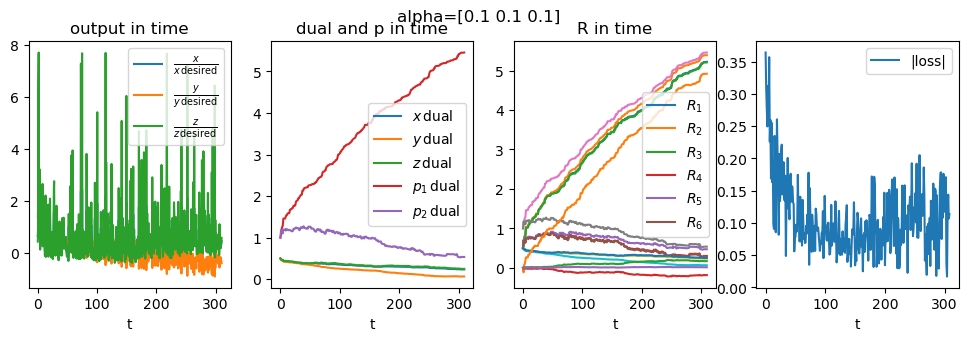

In [88]:
# Training + plot

state, variabs, desired = run_model_changing_alpha(alpha_vec, task_type, training, supress=False, bc_noise=0.0, use_p_tag=True)

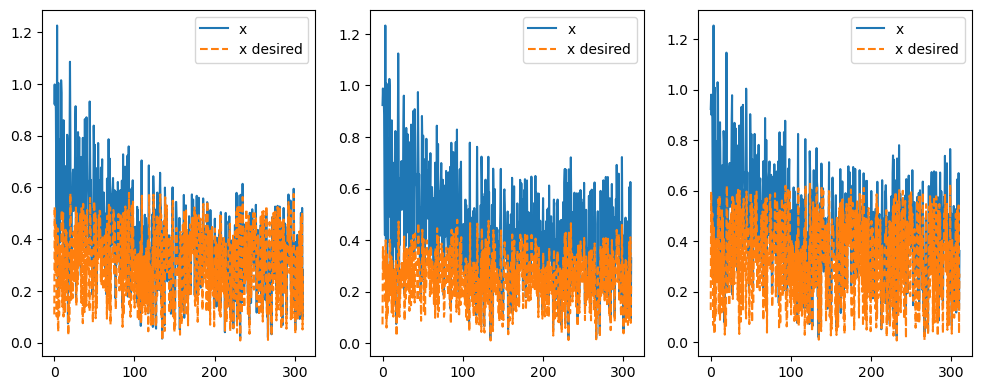

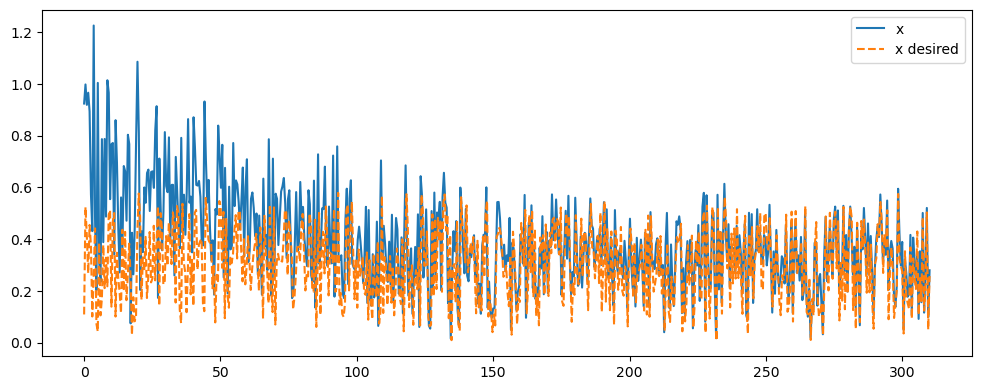

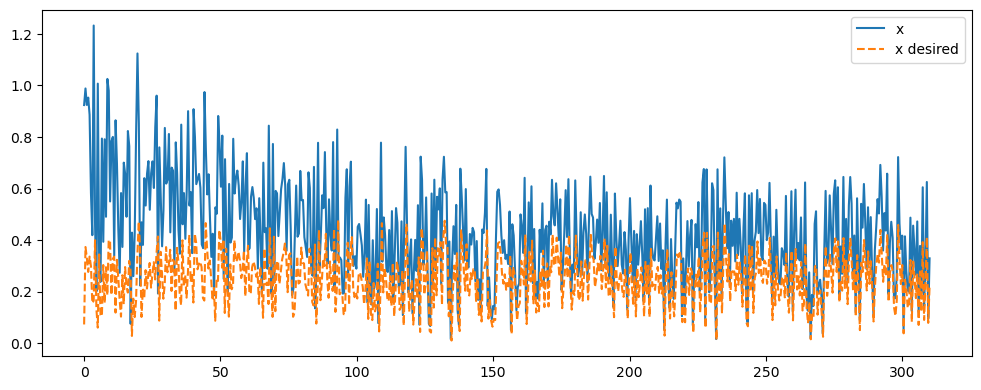

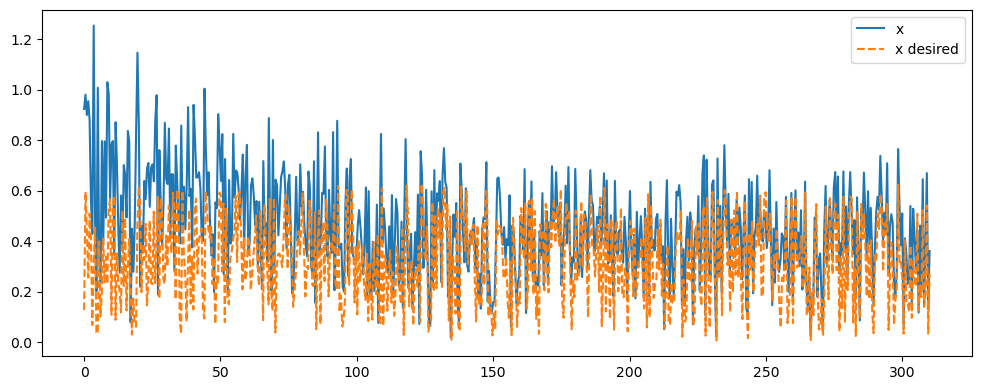

In [63]:
## This only works for "General Regression"

fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))
legend1 = ['x', 'x desired']
if variabs.task_type=='Allostery' or variabs.task_type=='Regression':
    pass
# regression goes only every two samples
elif task_type=='General_reg' or task_type=='General_reg_allRsChange':
    for i in range(3):
        axes[i].plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        axes[i].plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
        axes[i].legend(legend1)
        
for i in range(3):
    fig, axes = plt.subplots(1, 1, figsize=(12, 4.5))
    plt.plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
    plt.plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
    plt.legend(legend1)

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.2668974
 0.26640746 0.25247105 0.23492847 0.21947566 0.21825383 0.20309466
 0.18880905 0.17123732 0.17410051 0.16983217 0.17283532 0.15837762
 0.16201632 0.15675614 0.16075477 0.17055952 0.16942105 0.17057256
 0.17590244 0.17991429 0.16979478 0.16362107 0.16099597 0.15825177
 0.15255273 0.15160944 0.15612133 0.14902905 0.14112049 0.13790802
 0.13956393 0.13806667 0.13754881 0.13942898 0.13792625 0.14484397
 0.14407552 0.13852872 0.12820427 0.12446281 0.12202824 0.12043828
 0.11454448 0.11440073 0.11258502 0.11016125 0.10316044 0.10389198
 0.09906824 0.10470259 0.1037131  0.10849109 0.10937501 0.10840793
 0.10717112 0.09836517 0.09490365 0.09221587 0.09323405 0.090934
 0.09282122 0.09734803 0.09486249 0.09638443 0.09681441 0.09825359
 0.09586442 0.09951093 0.10171835 0.09842338 0.09881264 0.09735332
 0.09424308 0.0896032  0.09612418 0.09074825 0.08862574 0.0886804

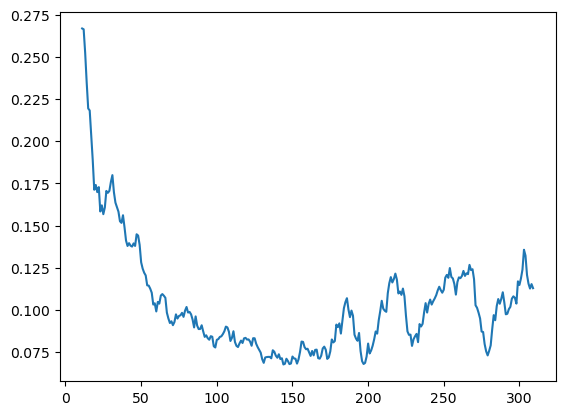

In [89]:
import pandas as pd

loss_1d_in_t = np.mean(np.mean(np.abs(state.loss_in_t), axis=1), axis=1)

# Convert the numpy array to a pandas Series
loss_series = pd.Series(loss_1d_in_t)

# Calculate the moving mean with a window size of 3
moving_mean = loss_series.rolling(window=12).mean()

# Convert back to numpy array if needed
moving_mean_array = moving_mean.to_numpy()

print(moving_mean_array)

# plt.plot(loss_1d_in_t)
plt.plot(moving_mean_array)

Text(0, 0.5, '$x,y$')

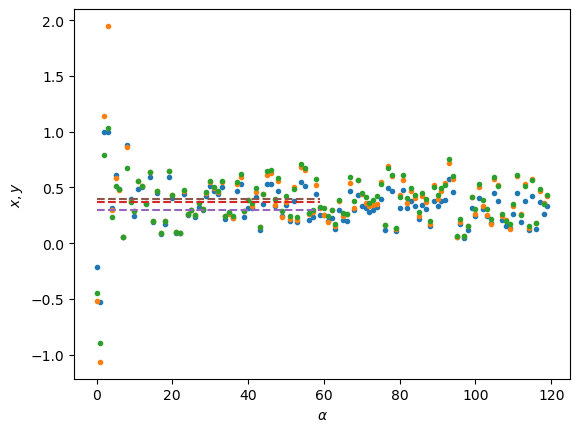

In [7]:
## plot the hysteresis curve
# it will work only if alpha is the same size as t

if len(alpha_vec.T) == len(state.out_in_t):
    plt.plot(alpha_vec.T, state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
    plt.xlim([min(alpha_vec[0])-0.01, max(alpha_vec[0]+0.01)])
else:
    plt.plot(state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$x,y$")